In [1]:
from Kitsune import Kitsune
import numpy as np
import time

Importing Scapy Library


#############################################################################
Kitsune a lightweight online network intrusion detection system based on an ensemble of autoencoders (kitNET).
For more information and citation, please see our NDSS'18 paper: Kitsune: An Ensemble of Autoencoders for Online Network Intrusion Detection

This script demonstrates Kitsune's ability to incrementally learn, and detect anomalies in recorded a pcap of the Mirai Malware.
The demo involves an m-by-n dataset with n=115 dimensions (features), and m=100,000 observations.
Each observation is a snapshot of the network's state in terms of incremental damped statistics (see the NDSS paper for more details)

The runtimes presented in the paper, are based on the C++ implimentation (roughly 100x faster than the python implimentation)
##################  Last Tested with Anaconda 3.6.3   #######################

In [2]:
'''# Load Mirai pcap (a recording of the Mirai botnet malware being activated)
# The first 70,000 observations are clean...
print("Unzipping Sample Capture...")
import zipfile
with zipfile.ZipFile("activewiretap.zip","r") as zip_ref:
    zip_ref.extractall()'''

'# Load Mirai pcap (a recording of the Mirai botnet malware being activated)\n# The first 70,000 observations are clean...\nprint("Unzipping Sample Capture...")\nimport zipfile\nwith zipfile.ZipFile("activewiretap.zip","r") as zip_ref:\n    zip_ref.extractall()'

In [3]:
# File location
path = "Fuzzing_pcap.pcapng" #the pcap, pcapng, or tsv file to process.
packet_limit = np.Inf #the number of packets to process

In [4]:
# KitNET params:
maxAE = 10 #maximum size for any autoencoder in the ensemble layer
FMgrace = 5000 #the number of instances taken to learn the feature mapping (the ensemble's architecture)
ADgrace = 50000 #the number of instances used to train the anomaly detector (ensemble itself)

In [5]:
# Build Kitsune
K = Kitsune(path,packet_limit,maxAE,FMgrace,ADgrace)

Parsing with tshark...
tshark parsing complete. File saved as: Fuzzing_pcap.pcapng.tsv
counting lines in file...
There are 2244140 Packets.
Feature-Mapper: train-mode, Anomaly-Detector: off-mode


In [6]:
print("Running Kitsune:")
RMSEs = []
i = 0
start = time.time()
# Here we process (train/execute) each individual packet.
# In this way, each observation is discarded after performing process() method.
while True:
    i+=1
    if i % 1000 == 0:
        print(i)
    rmse = K.proc_next_packet()
    if rmse == -1:
        break
    RMSEs.append(rmse)
stop = time.time()
print("Complete. Time elapsed: "+ str(stop - start))

Running Kitsune:
1000
2000
3000
4000
5000
The Feature-Mapper found a mapping: 100 features to 14 autoencoders.
Feature-Mapper: execute-mode, Anomaly-Detector: train-mode
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
Feature-Mapper: execute-mode, Anomaly-Detector: execute-mode
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000

1254000
1255000
1256000
1257000
1258000
1259000
1260000
1261000
1262000
1263000
1264000
1265000
1266000
1267000
1268000
1269000
1270000
1271000
1272000
1273000
1274000
1275000
1276000
1277000
1278000
1279000
1280000
1281000
1282000
1283000
1284000
1285000
1286000
1287000
1288000
1289000
1290000
1291000
1292000
1293000
1294000
1295000
1296000
1297000
1298000
1299000
1300000
1301000
1302000
1303000
1304000
1305000
1306000
1307000
1308000
1309000
1310000
1311000
1312000
1313000
1314000
1315000
1316000
1317000
1318000
1319000
1320000
1321000
1322000
1323000
1324000
1325000
1326000
1327000
1328000
1329000
1330000
1331000
1332000
1333000
1334000
1335000
1336000
1337000
1338000
1339000
1340000
1341000
1342000
1343000
1344000
1345000
1346000
1347000
1348000
1349000
1350000
1351000
1352000
1353000
1354000
1355000
1356000
1357000
1358000
1359000
1360000
1361000
1362000
1363000
1364000
1365000
1366000
1367000
1368000
1369000
1370000
1371000
1372000
1373000
1374000
1375000
1376000
1377000
1378000


In [7]:
# Here we demonstrate how one can fit the RMSE scores to a log-normal distribution (useful for finding/setting a cutoff threshold \phi)
from scipy.stats import norm
benignSample = np.log(RMSEs[FMgrace+ADgrace+1:100000])
logProbs = norm.logsf(np.log(RMSEs), np.mean(benignSample), np.std(benignSample))

Plotting results


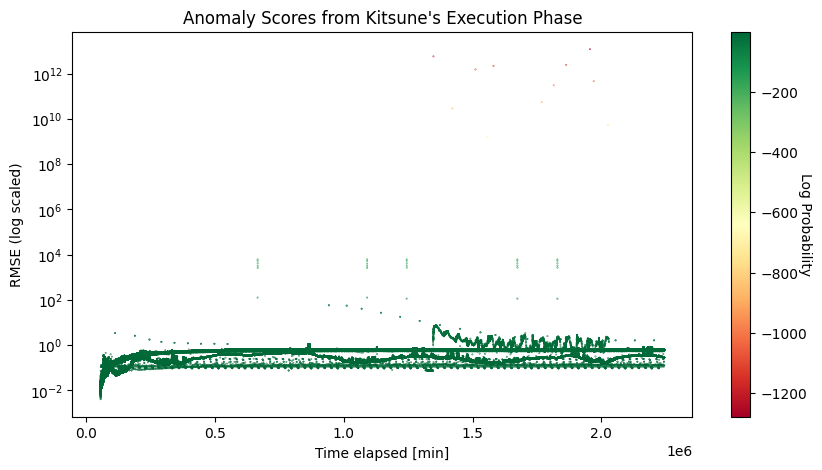

In [8]:
# plot the RMSE anomaly scores
print("Plotting results")
from matplotlib import pyplot as plt
from matplotlib import cm
plt.figure(figsize=(10,5))
fig = plt.scatter(range(FMgrace+ADgrace+1,len(RMSEs)),RMSEs[FMgrace+ADgrace+1:],s=0.1,c=logProbs[FMgrace+ADgrace+1:],cmap='RdYlGn')
plt.yscale("log")
plt.title("Anomaly Scores from Kitsune's Execution Phase")
plt.ylabel("RMSE (log scaled)")
plt.xlabel("Time elapsed [min]")
figbar=plt.colorbar()
figbar.ax.set_ylabel('Log Probability\n ', rotation=270)
plt.show()